## Problem Statement

Predict the loan defaulters using a Logistic Regression model on the credit risk data and calculate credit scores

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data exploration, preprocessing and visualization
* implement Logistic Regression using manual code or using sklearn library
* evaluate the model using appropriate performance metrics
* develop a credit scoring system

## Dataset

The dataset chosen for this mini-project is the [Give Me Some Credit](https://bigml.com/user/jbosca/gallery/dataset/5a7def3d2a83476e09000456#info) dataset which can be used to build models for predicting loan repayment defaulters

#### Datafields

- **SeriousDlqin2yrs:** Person experienced 90 days past due delinquency or worse
- **RevolvingUtilizationOfUnsecuredLines:** Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits
- **age:** Age of borrower in years
- **NumberOfTime30-59DaysPastDueNotWorse:** Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
- **DebtRatio:** Monthly debt payments, alimony,living costs divided by monthy gross income
- **MonthlyIncome:** Monthly income
- **NumberOfOpenCreditLinesAndLoans:** Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
- **NumberOfTimes90DaysLate:** Number of times borrower has been 90 days or more past due.
- **NumberRealEstateLoansOrLines:**	Number of mortgage and real estate loans including home equity lines of credit
- **NumberOfTime60-89DaysPastDueNotWorse:**	Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
- **NumberOfDependents:** Number of dependents in family excluding themselves (spouse, children etc.)

## Information

Credit risk arises when a corporate or individual borrower fails to meet their debt obligations. From the lender's perspective, credit risk could disrupt its cash flows or increase collection costs, since the lender may be forced to hire a debt collection agency to enforce the collection. The loss may be partial or complete, where the lender incurs a loss of part of the loan or the entire loan extended to the borrower.

Credit scoring algorithms, which calculate the probability of default, are the best methods that banks use to determine whether or not a loan should be granted.

In order to build a credit scoring system, the following feature transformations are performed:

#### Weight of Evidence and Information value

Logistic regression is a commonly used technique in credit scoring for solving binary classification problems. Prior to model fitting, another iteration of variable selection is valuable to check if the newly WOE transformed variables are still good model candidates. Preferred candidate variables are those with higher information value having a linear relationship with the dependent variable, have good coverage across all categories, have a normal distribution, contain a notable overall contribution, and are relevant to the business.

**Weight of evidence** (WOE) is a powerful tool for feature representation and evaluation in data science. WOE can provide interpret able transformation to both categorical and numerical features. The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable. Since it evolved from credit scoring world, it is generally described as a measure of the separation of good and bad customers. "Bad Customers" refers to the customers who defaulted on a loan. and "Good Customers" refers to the customers who paid back loan. WOE can be calculated using the below formula:

$$WOE = ln \left( \frac{\%   of  Non\_Events}{\%   of  Events} \right)$$

Steps to calculate WOE
* For a continuous variable, split data into 10 parts (or lesser depending on the distribution).
* Calculate the number of events and non-events in each group (bin)
* Calculate the % of events and % of non-events in each group.
* Calculate WOE by taking natural log of division of % of non-events and % of events

**Information value** is one of the most useful technique to select important variables in a predictive model. It helps to rank variables on the basis of their importance. The IV is calculated using the following formula :
$$IV = ∑ (\% of Non\_Events - \% of Events) * WOE$$

More about `WOE` and `IV` from the following [link](https://medium.com/@yanhuiliu104/credit-scoring-scorecard-development-process-8554c3492b2b)

### Download the dataset

In [ ]:
!pip install pandas
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/GiveMeSomeCredit.csv
!pip -qq install xverse

### Import Neccesary Packages

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
import math
from xverse.transformer import MonotonicBinning,WOE

### Load the dataset

In [3]:
train_data = pd.read_csv("GiveMeSomeCredit.csv")
train_data.head(2)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0


#### Describe the all statistical properties of the train dataset

In [4]:
train_data[train_data.columns[1:]].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


### Pre-processing

#### Remove unwanted columns

In [5]:
train_data.drop("Unnamed: 0",axis=1,inplace=True)

#### Handle the missing data

Find the how many null values in the dataset and fill with mean or remove.

In [6]:
train_data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [7]:
# Fill the missing values using mean
train_data= train_data.fillna((train_data.mean()))
train_data.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### EDA &  Visualization

#### Calculate the percentage of the target labels and visualize with a graph

In [8]:
train_data['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [9]:
total_len = len(train_data['SeriousDlqin2yrs'])
percentage_labels = (train_data['SeriousDlqin2yrs'].value_counts()/total_len)*100
percentage_labels

0    93.316
1     6.684
Name: SeriousDlqin2yrs, dtype: float64

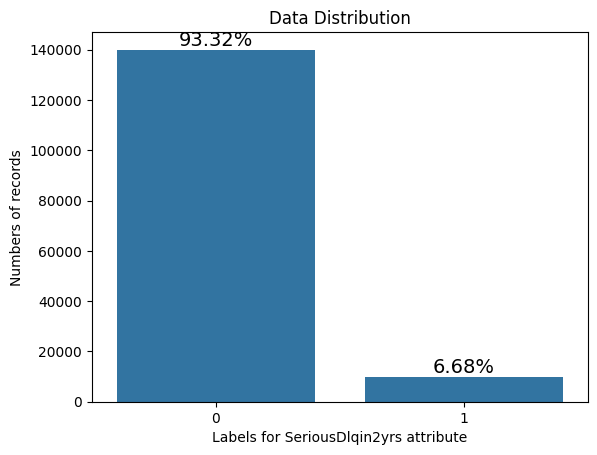

In [10]:
%matplotlib inline
sns.countplot(data = train_data, x='SeriousDlqin2yrs').set_title('Data Distribution')
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 2, '{:.2f}%'.format(100*(height/total_len)), fontsize=14, ha='center', va='bottom')
ax.set_xlabel("Labels for SeriousDlqin2yrs attribute")
ax.set_ylabel("Numbers of records")
plt.show()

#### Plot the distribution of SeriousDlqin2yrs by age

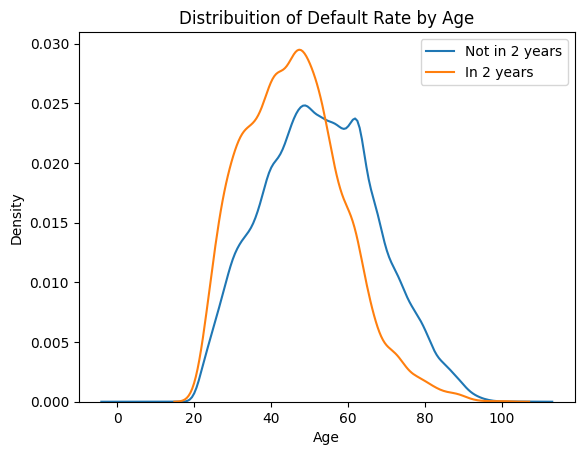

In [11]:
sns.kdeplot(train_data[train_data["SeriousDlqin2yrs"] == 0]["age"], label="Not in 2 years")
sns.kdeplot(train_data[train_data["SeriousDlqin2yrs"] == 1]["age"], label="In 2 years")
plt.xlabel('Age')
plt.title('Distribuition of Default Rate by Age')
plt.legend()
plt.show()

#### Correlation and the heatmap

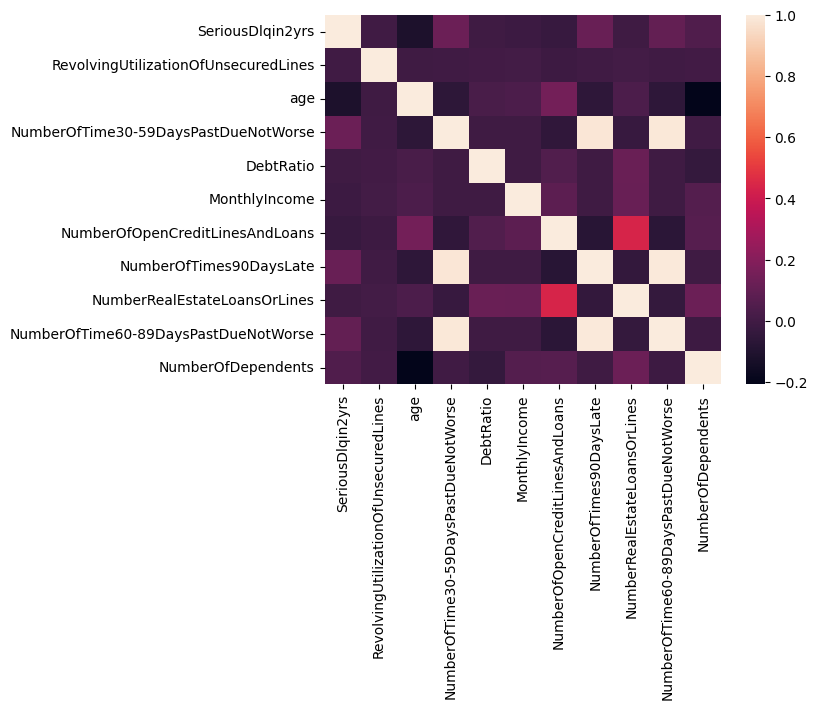

In [12]:
train_data[train_data.columns[:]].corr()
sns.heatmap(train_data[train_data.columns[:]].corr(),fmt=".1f")
plt.show()

### Data Engineering

#### Weight of Evidence and Information value

* Arrange the binning for each variable with different bins
    * For eg. Age = 49, Age_quantile_range = (48, 56)
* Calculate information value and chooose the best features based on the rules given below

| Information Value |	Variable Predictiveness |
| --- | --- |
| Less than 0.02	|  Not useful for prediction |
| 0.02 to 0.1	| Weak predictive Power |
|  0.1 to 0.3 | Medium predictive Power |
| 0.3 to 0.5 | Strong predictive Power |
| >0.5 | Suspicious Predictive Power |

* Calculate Weight of evidence for the selected variables


In [13]:
# Using xverse package
clf = MonotonicBinning()
clf.fit(train_data.iloc[:, 1:], train_data.iloc[:, 0])
out_X = clf.transform(train_data.iloc[:,1:])
out_X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,"(0.38, 50708.0]","(-0.001, 45.0]","(1.0, 98.0]","(0.57, 329664.0]","(6670.221, 3008750.0]","(10.0, 58.0]","(-0.001, 1.0]","(1.0, 54.0]","(-0.001, 1.0]","(1.0, 20.0]"
1,"(0.38, 50708.0]","(-0.001, 45.0]","(-0.001, 1.0]","(-0.001, 0.238]","(-0.001, 4700.0]","(-0.001, 6.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]"
2,"(0.38, 50708.0]","(-0.001, 45.0]","(-0.001, 1.0]","(-0.001, 0.238]","(-0.001, 4700.0]","(-0.001, 6.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]"
3,"(0.0544, 0.38]","(-0.001, 45.0]","(-0.001, 1.0]","(-0.001, 0.238]","(-0.001, 4700.0]","(-0.001, 6.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]"
4,"(0.38, 50708.0]","(45.0, 59.0]","(-0.001, 1.0]","(-0.001, 0.238]","(6670.221, 3008750.0]","(6.0, 10.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]"


In [14]:
# Using xverse package
clf = WOE()
clf.fit(train_data.iloc[:,1:], train_data.iloc[:,0])
out_X = clf.transform(train_data.iloc[:,1:])

In [15]:
out_X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.916188,0.414666,1.901126,0.146810,-0.336321,-0.043992,-0.176674,-0.066080,-0.09799,0.269384
1,0.916188,0.414666,-0.257826,-0.108543,0.300624,0.161831,-0.176674,0.024285,-0.09799,-0.088266
2,0.916188,0.414666,-0.257826,-0.108543,0.300624,0.161831,-0.176674,0.024285,-0.09799,-0.088266
3,-0.802015,0.414666,-0.257826,-0.108543,0.300624,0.161831,-0.176674,0.024285,-0.09799,-0.088266
4,0.916188,0.043658,-0.257826,-0.108543,-0.336321,-0.200293,-0.176674,0.024285,-0.09799,-0.088266


In [16]:
clf.iv_df #information value dataset

,Variable_Name,Information_Value
8,RevolvingUtilizationOfUnsecuredLines,0.935429
6,NumberOfTimes90DaysLate,0.484202
4,NumberOfTime30-59DaysPastDueNotWorse,0.471831
5,NumberOfTime60-89DaysPastDueNotWorse,0.264824
9,age,0.219843
1,MonthlyIncome,0.065725
2,NumberOfDependents,0.023730
3,NumberOfOpenCreditLinesAndLoans,0.023300
0,DebtRatio,0.012360
7,NumberRealEstateLoansOrLines,0.001605


In [17]:
selected_columns = clf.iv_df.Variable_Name.values[:5]

### Identify features,  target and split it into train and test

In [18]:
len(out_X.columns), len(selected_columns)

(10, 5)

In [19]:
train_data.iloc[:,1:]

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.000000,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.000000,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.000000,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.000000,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.000000,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...
149995,0.040674,74,0,0.225131,2100.000000,4,0,1,0,0.0
149996,0.299745,44,0,0.716562,5584.000000,4,0,1,0,2.0
149997,0.246044,58,0,3870.000000,6670.221237,18,0,1,0,0.0
149998,0.000000,30,0,0.000000,5716.000000,4,0,0,0,0.0


In [20]:
X = out_X[selected_columns]
y = train_data['SeriousDlqin2yrs']
X.shape, y.shape

((150000, 5), (150000,))

In [21]:
selected_columns

array(['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTimes90DaysLate',
       'NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfTime60-89DaysPastDueNotWorse', 'age'], dtype=object)

In [22]:
# split the data into train and test
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=66)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((120000, 5), (120000,), (30000, 5), (30000,))

### Logistic Regression from scratch using gradient method

For Linear Regression, we had the hypothesis $yhat = w.X +b$ , whose output range was the set of all Real Numbers.
Now, for Logistic Regression our hypothesis is  $yhat = sigmoid(w.X + b)$ , whose output range is between 0 and 1 because by applying a sigmoid function, we always output a number between 0 and 1.

$yhat = \frac{1}{1 +e^{-(w.x+b)}}$

In [23]:
intercept = np.ones((xtrain.shape[0], 1))
x_train = np.concatenate((intercept, xtrain), axis=1)
weight = np.zeros(x_train.shape[1])

In [24]:
weight.shape

(6,)

In [25]:
#Sigmoid method
def sigmoid(x, weight):
    z = np.dot(x, weight)
    return 1 / (1 + np.exp(-z))

def fit(x, y, weight, lr, iterations):
    for i in range(iterations):
        sigma = sigmoid(x, weight)
        loss = mean_squared_error(sigma,y)
        # gradient
        dW = np.dot(x.T, (sigma - y)) / y.shape[0]
        #Updating the weights
        weight -= lr * dW
    return weight

In [26]:
#creating the class Object
updated_weights = fit(x_train, ytrain, weight, 0.1 , 5000)

In [27]:
# Method to predict the class label.
def predict(x_new , weight, treshold):
    x_new = np.concatenate((np.ones((x_new.shape[0], 1)), x_new), axis=1)
    result = sigmoid(x_new, weight)
    result = result >= treshold
    y_pred = np.zeros(result.shape[0])
    for i in range(len(y_pred)):
        if result[i] == True:
            y_pred[i] = 1
        else:
            continue
    return y_pred

In [28]:
xtest.shape

(30000, 5)

In [29]:
y_pred = predict(xtest, updated_weights, 0.5)

In [30]:
# Accuracy of test data
(y_pred == ytest).sum() / len(y_pred)

0.9367

### Implement the Logistic regression using sklearn

As there is imbalance in the class distribution, add weightage to the Logistic regression.

* Find the accuracy with class weightage in Logistic regression
* Find the accuracy without class weightage in Logistic regression

In [31]:
# With weightage
log_reg = LogisticRegression(class_weight={0:6/100, 1: 94/100})
log_reg.fit(xtrain,ytrain)
log_reg.score(xtest,ytest), log_reg.score(xtrain, ytrain)

(0.6907, 0.6912583333333333)

In [32]:
test_predicted = log_reg.predict(xtest)

In [33]:
# Without weightage
log_reg = LogisticRegression()
log_reg.fit(xtrain,ytrain)
log_reg.score(xtest,ytest), log_reg.score(xtrain, ytrain)

(0.9367, 0.93545)

In [34]:
test_predicted = log_reg.predict(xtest)

In [35]:
log_reg.coef_, log_reg.intercept_

(array([[0.77033744, 0.60206246, 0.62024115, 0.39665405, 0.52257834]]),
 array([-2.60823093]))

In [36]:
log_reg.predict_proba

<bound method LogisticRegression.predict_proba of LogisticRegression()>

### Credit scoring

When scaling the model into a scorecard, we will need both the Logistic Regression coefficients from model fitting as well as the transformed WoE values. We will also need to convert the score from the model from the log-odds unit to a points system.
For each independent variable Xi, its corresponding score is:

$Score = \sum_{i=1}^{n} (-(β_i × WoE_i + \frac{α}{n}) × Factor + \frac{Offset}{n})$

Where:

βi — logistic regression coefficient for the variable Xi

α — logistic regression intercept

WoE — Weight of Evidence value for variable Xi

n — number of independent variable Xi in the model

Factor, Offset — known as scaling parameter

  - Factor = pdo / ln(2); pdo is points to double the odds
  - Offset = Round_of_Score - {Factor * ln(Odds)}

In [37]:
coef = log_reg.coef_.ravel()
intercept = log_reg.intercept_
factor = 20/np.log(2)
offset = 600 - ( factor * np.log(50))
factor, offset

(28.85390081777927, 487.1228762045055)

In [38]:
all_scores = []
for idx,row in X.iterrows():
  a = row.values * coef          # B_i * WOE_i
  a = a + (intercept/X.shape[1]) # (B_i * WOE_i) + intercept_i / n
  b = -a * factor                # -((B_i * WOE_i) + intercept_i / n) * factor
  b = b + (offset/X.shape[1])    # -((B_i * WOE_i) + intercept_i / n) * factor) + offset / n
  all_scores.append(sum(b))      # sum

In [39]:
max(all_scores),min(all_scores)

(614.1966472710151, 420.79476969364384)

In [40]:
len(set(all_scores))

70

### Performance Metrics

#### Precision

In [41]:
from sklearn.metrics import precision_score
precision_score(ytest, test_predicted ,average='macro')

0.7778018274901173

#### Recall

In [42]:
from sklearn.metrics import recall_score
recall_score(ytest, test_predicted,average='macro')

0.5484284892209297

#### Classification Report

In [43]:
from sklearn.metrics import classification_report
print(classification_report(ytest, test_predicted))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28026
           1       0.62      0.10      0.17      1974

    accuracy                           0.94     30000
   macro avg       0.78      0.55      0.57     30000
weighted avg       0.92      0.94      0.91     30000



#### Confusion matrix

In [44]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, test_predicted)
mat

array([[27901,   125],
       [ 1774,   200]])

### Result Explanation

* Accuracy:
  * The overall accuracy of the model is 94%, which is the proportion of correctly classified instances.
* Confusion Matrix:
  * Class 0 (SeriousDlqin2yrs = 0): 139974 instances
  * Class 1 (SeriousDlqin2yrs = 1): 10026 instances

  * True Positives (TP): 200
    * The model correctly identified 200 instances of individuals experiencing financial distress (SeriousDlqin2yrs = 1).
  * True Negatives (TN): 27901
    * The model correctly identified 27,901 instances of individuals not experiencing financial distress (SeriousDlqin2yrs = 0).
  * False Positives (FP): 125
    * The model incorrectly classified 125 instances as financial distress (SeriousDlqin2yrs = 1) when they are not.
  * False Negatives (FN): 1774
    * The model incorrectly classified 1774 instances as not experiencing financial distress (SeriousDlqin2yrs = 0) when they are.


### Future Improvements

* Handle Class imbalance
  * As we can clearly see that data has class imbalance where we have 139974 instances for Class 0 whereas only 10026 instances for class 1 so to  improve the model further I will balance the class using following techinques:
    * Resampling techniques: SMOTE, Random Oversampling, ADASYN etc
    * Data Augmentation
    * Class weights: By applying higher weights to the minority class
* Removing or adjusting outliers
